obtain the runtime for each classifier, given the best parameters

---

In [1]:
import os
import pandas as pd

In [2]:
import palettable
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
bm_base_dir = 'runtime/'
s3d_base_dir = 's3d-runtime/'

---

#### benchmark algorithms

In [4]:
file_list = [f for f in os.listdir(bm_base_dir)]
len(file_list)

18

for each dataset, average over model

In [5]:
runtime_df = list()
for f in file_list:
    data_name = f[:-4]
    #df = pd.read_csv(base_dir+f).groupby('clf_name').mean()
    df = pd.read_csv(bm_base_dir+f).query("clf_name!='s3d'")
    #df.reset_index(inplace=True, drop=False)
    df['data_name'] = data_name
    df.drop(columns=['fold_index'], inplace=True)
    runtime_df.append(df)
runtime_df = pd.concat(runtime_df, ignore_index=True)
runtime_df.head(2)

,clf_name,data_name,train_time
0,linearsvr,pol,0.256196
1,linearsvr,pol,0.198082


In [6]:
pd.np.all(runtime_df.groupby(['clf_name', 'data_name']).size().values == 50)

True

---

#### s3d

In [7]:
file_list = [f for f in os.listdir(s3d_base_dir)]
len(file_list)

18

In [8]:
s3d_runtime_df = list()
for f in file_list:
    data_name = f[:-4]
    runtime_arr = pd.np.loadtxt(s3d_base_dir+f)
    #print(runtime_arr.size)
    #break
    d = {'data_name': [f[:-4]]*runtime_arr.size,
         'train_time': runtime_arr
        }
    s3d_runtime_df.append(pd.DataFrame(d))
s3d_runtime_df = pd.concat(s3d_runtime_df, ignore_index=True)
s3d_runtime_df['clf_name'] = 's3d'
s3d_runtime_df.head(2)

,data_name,train_time,clf_name
0,building_sales,1.680212,s3d
1,building_sales,1.570625,s3d


---

#### visualize

In [9]:
df = s3d_runtime_df.append(runtime_df, ignore_index=True, sort=True)
pd.np.all(df.groupby(['clf_name', 'data_name']).size().values == 50)

True

In [10]:
import json
name_pair_dict = json.load(open("../data/name_pair.json"))

In [11]:
idx_arr = df[df.clf_name.str.startswith('linearsv')].index.values
df.loc[idx_arr, 'clf_name'] = 'linearsvm'

In [12]:
data_list = [
             "breastcancer", "spambase", "spectf", "parkinsons",
             "stackoverflow_cleaned_subset", "khan_cleaned",
             "digg", "twitter", "duolingo_cleaned",
             "appenergy", "building_sales", "building_costs",
             "pol", "breastcancer_reg",  
             "boston_housing", "triazines",
             "parkinsons_motor", "parkinsons_total",
            ]

In [13]:
order_list = ['linearsvm', 'randomforest', 
              #'randomforest_2k', 'randomforest_k',
              'lasso', 'elasticnet', 's3d', 
             ]

In [14]:
color_list = pd.np.asarray(palettable.cartocolors.qualitative.Bold_7.mpl_colors)
#color_list = color_list[[2,5,6,4,3,1,0]]
color_list = color_list[[2,5,3,1,0]]

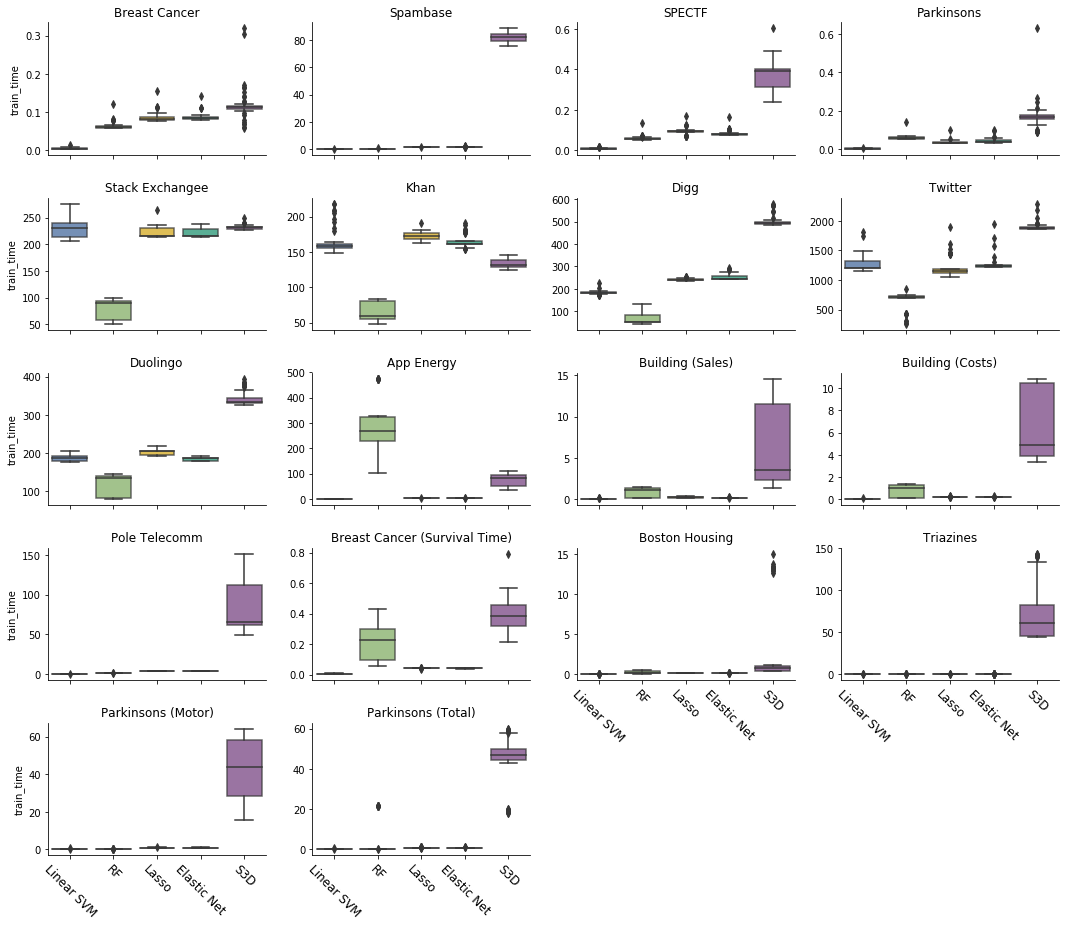

In [15]:
g = sns.factorplot(x='clf_name', y='train_time', data=df,
                   col='data_name', col_wrap=4, col_order=data_list,
                   order=order_list, aspect=1.5, size=2.5,
                   width=0.8, boxprops=dict(alpha=.75),
                   palette=color_list,
                   sharey=False, kind='box')
for ax_i in g.axes:
    ax_i.set_title(name_pair_dict[ax_i.get_title().split(' = ')[-1]])
g.set_xlabels('')
g.set_xticklabels(['Linear SVM', 'RF', 'Lasso', 'Elastic Net' ,'S3D', ], size=12, rotation=-45)

In [16]:
g.savefig('figures/runtime.pdf', format='pdf', dpi=1000)